In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity

## Data Preparation:

First, I will save Zoya's script for cleaning categories that I've modified for my dataset:

In [5]:
random_categories = ['Apartments', 'Arcades', 'Art Galleries', 'Aquariums', 'Adult Entertainment', 'Arabic',
                     'Active Life', 'Arts & Entertainment','Arts & Crafts','Appliances', 'Bar Crawl', 'Adult',
                     'Health Markets', 'Boat Charters','Bike Repair/Maintenance','Bikes', 'Books','Boating',
                     'Bowling','Barbers','Cabaret','Cultural Center','Christmas Trees','Cooking Classes',
                     'Custom Cakes','Community Service/Non-Profit','Convenience Stores','Cooking Schools',
                     'Country Clubs','Caterers','Cafeteria','Dance Clubs','Eatertainment','Education',
                     'Event Planning & Services','Flowers & Gifts','Fitness & Instruction','Fruits & Veggies', 
                     'Furniture Stores',  
                     'Food',  'Fashion','Gift Shops','Gyms','Grocery','Hotels',  'Home Services','Jazz & Blues',
                     'Karaoke','Landmarks & Historical Buildings','Local Services','Local Flavor','Lounges',
                     'Mass Media','Music Venues','Musicians','Party & Event Planning','Personal Chefs',
                     'Public Services & Government', 'Photographers', 'Pubs','Pool Halls','Real Estate',
                     'Resorts', 'Restaurants','Social Clubs','Souvenir Shops', 'Shopping','Specialty Schools',
                     'Tobacco Shops', 'Tours',  'Venues & Event Spaces','Wholesale Stores','Teppanyaki',
                     'Heating & Air Conditioning/HVAC','Kitchen & Bath','Pretzels','Religious Organizations',
                     'Restaurant Supplies','Salvadoran', 'Travel Agents','Travel Services','Wholesalers',
                     'Yelp Events','Herbs & Spices','Nicaraguan', 'Pop-up Shops', 'Discount Store','Drugstores', 
                     'Vape Shops',
                     'Vitamins & Supplements','Health & Medical','Nutritionists','Smokehouse', 'Parks', 
                     'Holiday Decorations',
                     'Day Spas','Hair Salons', 'Performing Arts','Skin Care', 'Supernatural Readings',
                     'Tabletop Games','Sports Wear','Organic Stores','Professional Services','Indoor Playcentre',
                     'Kids Activities', 'Sporting Goods','Mags', 'Tree Services','Sporting Goods', 'Home Decor',
                     'Golf', 'Herbal Shops''Shared Office Spaces','Beauty & Spas', 'Music & Video',
                      'Swimming Pools', 'Shared Office Spaces','Gas Stations','Wedding Planning', 
                     'Cards & Stationery',
                      'Nurseries & Gardening','Party Supplies', 'Electronics Repair','Health Markets',
                     'Home & Garden','British', 
                      'Malaysian', 'Egyptian', 'Polish', 'Russian', 'Ukrainian','Burmese','Arabic', 'Shanghainese', 
                     'Argentine', 'Laotian',
                      'Acai Bowls', 'Shanghainese','Haitian','Candy Stores','Szechuan','Venezuelan','Basque',
                     'Pasta Shops','Empanadas', 'Fondue', 'Argentine', 
                      'Pan Asian','Kebab','Lebanese','Pakistani','Colombian','Halal','Falafel']


categories_to_combine = [['Distilleries', 'Wine & Spirits', 'Wine Tasting Room', 'Bars', 'Beer', 'Brewpubs', 
                          'Breweries', 'Wineries', 'Nightlife'],
                        ['Auction Houses', 'Farmers Market'], ['Coffee & Tea', 'Coffee Roasteries', 'Cafes'],
                        ['Waffles', 'Bagels', 'Creperies', 'Breakfast & Brunch'],
                        ['Ice Cream & Frozen Yogurt', 'Gelato'],
                        ['Peruvian', 'Caribbean', 'Cuban',"Brazilian", 'Mexican', 'Tacos', 'Honduran', 
                         'Tapas/Small Plates', 'Latin American'], 
                        ['Meat Shops', 'Butcher'], ['Poke','Hawaiian'], 
                        ['Greek', 'Mediterranean', 'Middle Eastern'],
                        ["Korean", "Taiwanese", "Noodles", "Ramen", "Chinese", "Dim Sum", 
                         "Japanese", "Asian Fusion"],
                        ['Vegan', 'Vegetarian'], ['Filipino', "Vietnamese", "Thai"],
                        ["German", 'Brasseries', "French", "Italian", "Irish", "Spanish", 'Modern European'],
                        ["Burgers", "Hot Dogs", 'Fish & Chips',"Pizza", 'Chicken Wings'],
                        ['Chocolatiers & Shops', 'Donuts', 'Desserts', 'Bakeries','Macarons', 
                         'Patisserie/Cake Shop', 'Bakeries', 'Cupcakes'],
                        ['American (New)', 'American (Traditional)', 'Barbeque', 'Cheesesteaks', 
                         'Southern', 'Steakhouses'], ['African', 'Ethiopian']]

titles = ['Alcohol','Markets','Coffee_and_Tea', 'Breakfast', 
        'Frozen_Desserts', 'Latin American', 'Butcher', 'Hawaiian/Poke', 'Mediterranean',
        'East Asian', 'Vegan/Vegetarian', 'Southeast Asian', 'European', 'Fast Food', 
          'Desserts', 'American', 'African']

# -------------------------------------------------------Functions to help cleaning  ------------------------
"""
combineCols(names, col_llist, df)
    names = list of names of new columns 
    col_list = list of lists where each sublist contains the columns to combine
    df = original df 
    function to combine columns so that it takes two columns such as 'Nightlife' and 'Pubs'and creates 
    a new column of 0s and 1s which is 1 whereever Nightlife or Pubs is 1
    the two original columns are dropped from the dataframe and the new column is concatenated 
"""
def combineCols(names, col_list, df): 
    for name, cols in zip(names, col_list):
        
        # create a new column with the maximum value between the selected columns using a lambda function
        new_col = df[cols].apply(lambda row: max(row), axis=1)

        # drop the selected column
        df = df.drop(cols, axis=1)
        # add new column
        df[name] = new_col
    
    return df

Next, I'll read in my notebook. Note that this is essentially the exact same notebook as my previous recommender model, but this one uses the cleaned categories script that Zoya created. We'll build the recommender using these cleaned categories and see if the results are different.

In [3]:
# read in business data
nolaBus = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/csv_files/nolaRestaurants.csv')

# read in reviews data
nolaReviews = pd.read_csv('/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/csv_files/yelp_review.csv')

In [4]:
# filter to columns of interest
nolaBus2 = nolaBus[['business_id', 'name', 'postal_code', 'latitude', 'longitude', 
                   'stars', 'review_count', 'is_open', 'categories']]

# rename columns
nolaBus2 = nolaBus2.rename(columns = {'stars':'businessRating', 'review_count': 'businessReviewCount'})

# filter to only include restaurants with 50 or more reviews
nolaBus2 = nolaBus2[nolaBus2['businessReviewCount'] >= 50]

# filter to columns of interest
nolaReviews2 = nolaReviews[['review_id', 'user_id', 'business_id', 'stars']]

# rename columns
nolaReviews2 = nolaReviews2.rename(columns = {'stars':'userRating'})

# merge dataframes
nola = pd.merge(left = nolaBus2, right = nolaReviews2, how = 'inner', on = 'business_id')

# get list of users with 10 or more reviews
usersGreater10Reviews = nola['user_id'].value_counts()[nola['user_id'].value_counts() >= 10].index.tolist()

# filter out users with less than 10 reviews
nola2 = nola[nola.user_id.isin(usersGreater10Reviews)]

# drop instances where users reviewed the same restaurant twice 
# use this when filtering on users with greater than 10 reviews
nola2 = nola2.drop_duplicates(['user_id', 'business_id'], keep = 'first')

In [12]:
# clean categories based on Zoya's method
nola3 = nola2.drop(['business_id', 'review_id', 'postal_code',
                     'latitude', 'longitude', 'businessRating',
                     'businessReviewCount', 'is_open', 'name'], axis = 1)[['user_id', 'userRating', 'categories']]

nola_cat = nola3['categories'].str.get_dummies(sep = ', ')

to_drop = [col for col in random_categories if col in nola_cat.columns]
nola_cat = nola_cat.drop(to_drop, axis = 1) 

nola_cat = combineCols(titles, categories_to_combine, nola_cat)

nola4 = pd.merge(nola3, nola_cat, how = 'inner', left_index = True, right_index = True) \
               .drop('categories', axis = 1)

In [13]:
# Copy the DataFrame to avoid modifying the original data
nola5 = nola4.copy()

In [14]:
# Identify categories
categories = [col for col in nola5.columns.tolist() if col != 'user_id' and col != 'userRating']

In [15]:
# Input category columns with the star ratings the user has given that restaurant

# Identify categories
categories = [col for col in nola5.columns.tolist() if col != 'user_id' and col != 'userRating']

# For each row, where category = 1, assign the star rating that user gave that restaurant
for _, row in nola5.iterrows():
    # Get the user's star rating for the restaurant
    rating = row['userRating']
    
    # Iterate over each category column
    for col in categories:
        # Check if the restaurant belongs to the current category
        if row[col] == 1:
            # Fill the category column with the user's star rating
            nola5.loc[_, col] = rating

In [16]:
nola5.shape

(96218, 86)

#### Instead:
1. Identify users who have rated 10 or more total categories first
2. Filter dataframe to those users
3. Take average

In [17]:
# Create boolean mask for categories greater than 0
category_mask = nola5[categories] > 0

# Count the number of categories greater than 0 for each user
category_counts = category_mask.groupby(nola5['user_id'])[categories].sum()

# Filter out users who reviewed less than 10 categories
category_counts['num_categories_reviewed'] = category_counts.sum(axis = 1)
filtered_users = category_counts[category_counts['num_categories_reviewed'] >= 10].index

In [18]:
# Create new dataframe with only users who have reviews for 10 or more categories
nola6 = nola5[nola5['user_id'].isin(filtered_users)]

In [19]:
# Create new dataframe grouped by 
nola7 = nola6.groupby('user_id')[categories].agg(lambda x: np.mean(x[x > 0])).reset_index()

In [20]:
# Number of users in dataframe who have rated 10 or more restaurants
nola7['user_id'].nunique()

4733

In [21]:
# Number of users who have ratings for 10 or more restaurant categories
len(filtered_users)

4733

#### As a reminder to myself, the dataframe I'm working with is filtered on the following:
1. Restaurants with 50 or more reviews
2. Users who have rated 10 or more restaurants
3. Users who have ratings for 10 or more categories

Note that I need to filter on the above for 1) performance reasons and 2) I need a minimum number of categories for testing purposes. For each user, I need at least 6 categories to train on, 2 for the validation set and 2 for the test set.

In [23]:
# Check percentage of nulls
nola7.isna().sum() / len(nola7)

user_id            0.000000
Art Tours          0.985633
Automotive         0.995986
Bed & Breakfast    0.987534
Beer Bar           0.861821
                     ...   
Southeast Asian    0.639130
European           0.147475
Desserts           0.270442
American           0.003169
African            0.945489
Length: 85, dtype: float64

In [24]:
# See shape
nola7.shape

(4733, 85)

- We have 4,734 users who meet the desired criteria

## Calculating the sparsity:

In [25]:
nola7.head(10)

,user_id,Art Tours,Automotive,Bed & Breakfast,Beer Bar,Beer Gardens,Boat Tours,Bubble Tea,Buffets,Cajun/Creole,...,Butcher,Hawaiian/Poke,Mediterranean,East Asian,Vegan/Vegetarian,Southeast Asian,European,Desserts,American,African
0,-0LGLx8LP5dq3zcGO4Bebw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,...,NaN,NaN,NaN,5.000000,5.00,NaN,2.000000,3.0,3.555556,NaN
1,-13RX4Gy_F-zoLIenWAo-w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.333333,...,NaN,4.0,5.0,4.000000,5.00,NaN,4.857143,5.0,4.250000,NaN
2,-154QAmLwXOsKqChHSeWJQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,5.000000,4.00,NaN,3.000000,NaN,3.750000,NaN
3,-1MiSauypbVtNnWts4aXpA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,...,NaN,4.5,5.0,5.000000,4.50,NaN,2.000000,3.5,3.600000,NaN
4,-22PBmQh7bBWbNX1irrkPQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.200000,...,5.0,NaN,NaN,NaN,NaN,NaN,4.000000,5.0,5.000000,NaN
5,-2PIzrbasYWAggcNS2ptGw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,NaN,NaN,NaN,3.666667,3.75,5.0,4.000000,5.0,4.333333,NaN
6,-4YEZRxp3TwFKtNlzylx_Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.000000,...,NaN,5.0,NaN,4.333333,NaN,NaN,5.000000,4.6,3.333333,NaN
7,-6rFcyKGC-B7C89FzLyBeA,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,...,NaN,NaN,5.0,5.000000,5.00,5.0,5.000000,5.0,4.250000,NaN
8,-BVK-mFx5n0bPtulAPpXew,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600000,...,NaN,NaN,3.0,NaN,NaN,NaN,5.000000,3.0,3.400000,NaN
9,-Bo3nX8KSLzUSYVS-6c5Ag,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.142857,...,NaN,5.0,NaN,NaN,4.00,NaN,5.000000,5.0,4.444444,NaN


In [26]:
totalNulls = nola7.isnull().values.sum()
dfSize = nola7.size
print("Sparsity: {0:.0%}".format(totalNulls/dfSize))

Sparsity: 74%


- 74% total sparsity is honestly not bad compared to what we were working with before

### Normalize the data:

In [27]:
# Compute average rating across columns
avg_ratings = nola7.mean(axis = 1)

# Create copy of nola7
nola8 = nola7.copy()

# Normalize dataframe
numeric_columns = nola8.select_dtypes(include = [int, float]).columns
nola8[numeric_columns] = nola8[numeric_columns].sub(avg_ratings, axis = 0)

# Fill nulls with 0
nola8 = nola8.fillna(0)

# Set index as user_id
nola8 = nola8.set_index('user_id')

/var/folders/w3/x0690xnx12bcnwv0x7n6s4q00000gn/T/ipykernel_41811/4168677797.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  avg_ratings = nola7.mean(axis = 1)


## Building the model:

### Split test, training and validation sets:

Next I to identify a way to segment the dataframe such that we can split out test, training and validation sets:
1. For each row, randomly select 70% of the non-null values for our training set and 30% of the non-null values each for our test set

In [29]:
nola9 = nola8.copy()

In [30]:
def train_test_split(ratings, seed = 42):
    random_seed = np.random.seed(seed)
    ratings_array = ratings.values  # Convert DataFrame to NumPy array
    test = np.zeros(ratings.shape)
    train = ratings.values.copy()
    for user in range(ratings_array.shape[0]):
        test_ratings = np.random.choice(ratings_array[user, :].nonzero()[0], 
                                        size = int(0.2*len((ratings_array[user, :].nonzero()[0]))), 
                                        replace = False)
        train[user, test_ratings] = 0
        test[user, test_ratings] = ratings_array[user, test_ratings]

    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [31]:
train, test = train_test_split(nola9, 42)

In [32]:
train, val = train_test_split(pd.DataFrame(train).copy(), 42)

### Performing SVD:

On Validation Set:

In [33]:
# Perform SVD
U, sigma, Vt = svds(train)
sigma = np.diag(sigma)
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

In [34]:
# Create a dataframe from the SVD recalculation 
user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                   index = nola9.index,
                                   columns = nola9.columns)

## Evaluating Model:

- Recommendation engines use a different method for evaluating performance than more traditional machine learning projects. This is again because of sparsity, where because most users haven't reviewed many restaurants, and most restaurants don't have a ton of reviews, we can't just take a segment of rows or columns to test on as many of the values within this segment will have nulls
- Because of this, we take a subset of the dataframe where users have given ratings, save those indices and their values, and convert them to nulls. Once we perform SVD and generate our predictions, we compare the actual values to the predicted values and compute RMSE.

In [36]:
# 'De-normalize' validation set
recalculated_val = np.where(val == 0, None, val + avg_ratings.values.reshape(-1, 1))
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

# Get RMSE of validation set
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)
result = recalculated_val.subtract(user_ratings_filled)**2
rmse = np.sqrt(result.sum().sum() / result.count().sum())
print('RMSE Validation Set:', rmse)

# Get MAE of validation set
result_mae = abs(recalculated_val.subtract(user_ratings_filled))
mae = result_mae.sum().sum() / result.count().sum()
print('MAE Validation Set:', mae)

RMSE Validation Set: 0.7291790035461085
MAE Validation Set: 0.5287302967749751


Note that RMSE and MAE scores above aren't terribly useful as we haven't yet identified the optimal value of k

## Find optimal value of k

Next I want to try the above on different values of k with the goal of identifying the value of k that minimizes the RMSE:

In [39]:
# define range of k values
k_array = np.arange(2, 84)

# define validation rmse and mae empty lists to store results
val_rmse_list = []
val_mae_list = []

In [40]:
for k in k_array:
    # Perform SVD
    U, sigma, Vt = svds(train, k)
    sigma = np.diag(sigma)
    recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
    recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

    # Create a dataframe from the SVD recalculation 
    user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                       index = nola9.index,
                                       columns = nola9.columns)
    
    # 'De-normalize' validation set
    recalculated_val = np.where(val == 0, None, val + avg_ratings.values.reshape(-1, 1))
    recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

    # Get RMSE of validation set
    result = recalculated_val.subtract(user_ratings_filled)**2
    rmse = np.sqrt(result.sum().sum() / result.count().sum())
    val_rmse_list.append(rmse)
    
    # Get MAE of validation set
    result_mae = abs(recalculated_val.subtract(user_ratings_filled))
    mae = result_mae.sum().sum() / result.count().sum()
    val_mae_list.append(mae)

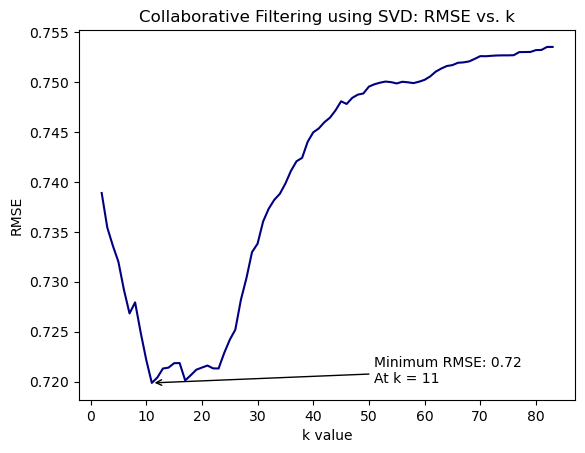

In [41]:
# Visualize RMSE vs k
plt.plot(k_array, val_rmse_list, label = 'Val RMSE', color = 'navy')
plt.title('Collaborative Filtering using SVD: RMSE vs. k')
plt.ylabel('RMSE')
plt.xlabel('k value')

min_rmse = min(val_rmse_list)
min_k = k_array[val_rmse_list.index(min_rmse)]

plt.annotate(f'Minimum RMSE: {min_rmse:.2f}\nAt k = {min_k}',
             xy = (min_k, min_rmse),
             xytext = (min_k + 40, min_rmse),
             arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
             )

plt.show()

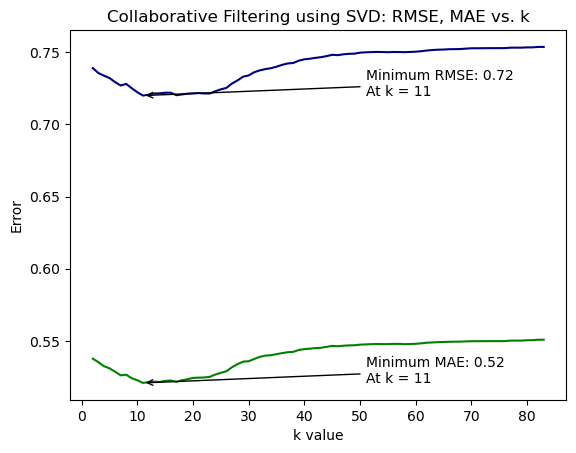

In [42]:
# Visualize RMSE vs k
plt.plot(k_array, val_rmse_list, label = 'Val RMSE', color = 'navy')
plt.plot(k_array, val_mae_list, label = 'Val MAE', color = 'green')
plt.title('Collaborative Filtering using SVD: RMSE, MAE vs. k')
plt.ylabel('Error')
plt.xlabel('k value')

min_rmse = min(val_rmse_list)
min_k = k_array[val_rmse_list.index(min_rmse)]

plt.annotate(f'Minimum RMSE: {min_rmse:.2f}\nAt k = {min_k}',
             xy = (min_k, min_rmse),
             xytext = (min_k + 40, min_rmse),
             arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
             )

min_mae = min(val_mae_list)
min_k = k_array[val_mae_list.index(min_mae)]

plt.annotate(f'Minimum MAE: {min_mae:.2f}\nAt k = {min_k}',
             xy = (min_k, min_mae),
             xytext = (min_k + 40, min_mae),
             arrowprops = dict(facecolor = 'black', arrowstyle = '->'),
             )

plt.show()

## Testing with optimal k = 11 on test and validation sets:

### Validation set:

In [43]:
# Perform SVD
U, sigma, Vt = svds(train, k = 11)
sigma = np.diag(sigma)
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

# Create a dataframe from the SVD recalculation 
user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                   index = nola9.index,
                                   columns = nola9.columns)

# 'De-normalize' val set
recalculated_val = np.where(val == 0, None, val + avg_ratings.values.reshape(-1, 1))
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

# Get RMSE of validation set
recalculated_val = pd.DataFrame(recalculated_val, columns = user_ratings_filled.columns, index = user_ratings_filled.index)
result = recalculated_val.subtract(user_ratings_filled)**2
rmse_val = np.sqrt(result.sum().sum() / result.count().sum())
print('RMSE Validation Set:', rmse_val)

# Get MAE of validation set
result_mae = abs(recalculated_val.subtract(user_ratings_filled))
mae_val = result_mae.sum().sum() / result.count().sum()
print('MAE Validation Set:', mae_val)

RMSE Validation Set: 0.7198602251569521
MAE Validation Set: 0.5209678014199454


### Test set:

In [44]:
# Perform SVD
U, sigma, Vt = svds(train, k = 11)
sigma = np.diag(sigma)
recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

# Create a dataframe from the SVD recalculation 
user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                   index = nola9.index,
                                   columns = nola9.columns)

# 'De-normalize' test set
recalculated_test = np.where(test == 0, None, test + avg_ratings.values.reshape(-1, 1))
recalculated_test = pd.DataFrame(recalculated_test, columns = user_ratings_filled.columns, index = user_ratings_filled.index)

# Get RMSE of test set
recalculated_test = pd.DataFrame(recalculated_test, columns = user_ratings_filled.columns, index = user_ratings_filled.index)
result = recalculated_test.subtract(user_ratings_filled)**2
rmse_test = np.sqrt(result.sum().sum() / result.count().sum())
print('RMSE Test Set:', rmse_test)

# Get MAE of test set
result_mae = abs(recalculated_test.subtract(user_ratings_filled))
mae_test = result_mae.sum().sum() / result.count().sum()
print('MAE Test Set:', mae_test)

RMSE Test Set: 0.7221380337032998
MAE Test Set: 0.5210546005584477


#### Saving model scores to compare with group:

In [70]:
# save model scores in dataframe
model_scores = {'RMSE Val': [rmse_val], 'RMSE Test': [rmse_test],
                'MAE Val': [mae_val], 'MAE Test': [mae_test]}

model_scores = pd.DataFrame.from_records(model_scores, index = ['Collaborative Filtering: Cleaned Categories'])

# specify file path
path = '/Users/analeegraig/Documents/Semester 2/Machine Learning & Data Mining/Final Project/machine-learning-dse-i210-final-project-yelprestaurantrecommender/notebooks'
file_name = '/model_scores.csv'

# save to csv
test_scores = pd.read_csv(path + file_name).set_index('Unnamed: 0')
test_scores_merged = pd.concat([test_scores, model_scores])
test_scores_merged.to_csv(path + file_name)

## Takeaways:

1. The RMSE and MAE for both the test and validation indicate that our model is overfitting slightly.

## Finding Similar Users:

In [71]:
# calculate cosine similarity for users
similarities = cosine_similarity(user_ratings_filled)

In [72]:
# store cosine similarities in dataframe
cosine_similarity_df = pd.DataFrame(similarities, 
                                    index = user_ratings_filled.index, 
                                    columns = user_ratings_filled.index)

In [73]:
# check dataframe
cosine_similarity_df.head()

user_id,-0LGLx8LP5dq3zcGO4Bebw,-13RX4Gy_F-zoLIenWAo-w,-154QAmLwXOsKqChHSeWJQ,-1MiSauypbVtNnWts4aXpA,-22PBmQh7bBWbNX1irrkPQ,-2PIzrbasYWAggcNS2ptGw,-4YEZRxp3TwFKtNlzylx_Q,-6rFcyKGC-B7C89FzLyBeA,-BVK-mFx5n0bPtulAPpXew,-Bo3nX8KSLzUSYVS-6c5Ag,...,zooLE09tPEnZJrJeXe4D4Q,zox0bzk1LvmLb77fmcRjUQ,zpcZzNtQE6vuMekqEV1jYw,zqh6jyBabvzC92bxW2Gjyg,zrESudirjip-s8wxxAB0xw,zta_5JXUGLPv_6szNTE0qQ,zwy1ik1ICsC-Ckzr9BKsvA,zx4c7K-1eBSvEmUg7zqiZQ,zxyKewY6p0CjnFprEutaog,zy0el7c-IO4BvjxUgj-ZSw
user_id,,,,,,,,,,,,,,,,,,,,,
-0LGLx8LP5dq3zcGO4Bebw,1.000000,0.993600,0.994660,0.996782,0.994551,0.990716,0.993907,0.994381,0.990178,0.992541,...,0.988630,0.990762,0.995276,0.993622,0.993693,0.992411,0.993656,0.993425,0.992901,0.989552
-13RX4Gy_F-zoLIenWAo-w,0.993600,1.000000,0.999001,0.997167,0.998897,0.996265,0.998705,0.999651,0.998376,0.999100,...,0.993303,0.997599,0.999394,0.998996,0.999691,0.995801,0.999513,0.998894,0.999305,0.996808
-154QAmLwXOsKqChHSeWJQ,0.994660,0.999001,1.000000,0.998037,0.998531,0.996031,0.998040,0.999001,0.996873,0.997690,...,0.994431,0.996983,0.998659,0.998432,0.998931,0.993072,0.998545,0.998088,0.998322,0.995273
-1MiSauypbVtNnWts4aXpA,0.996782,0.997167,0.998037,1.000000,0.998884,0.995416,0.997548,0.997939,0.994787,0.996755,...,0.992837,0.996528,0.998352,0.997705,0.997571,0.993294,0.998038,0.997065,0.997836,0.994737
-22PBmQh7bBWbNX1irrkPQ,0.994551,0.998897,0.998531,0.998884,1.000000,0.996786,0.999109,0.999515,0.997773,0.999246,...,0.991697,0.998830,0.999417,0.999384,0.999429,0.996308,0.999633,0.999138,0.999472,0.996931


In [74]:
# get top 3 most similar users for random user
cosine_similarity_df.loc['-0LGLx8LP5dq3zcGO4Bebw'].sort_values(ascending = False)[1:4]

user_id
wFinBme5oj01AiiFB1UdFw    0.996992
cTITrWiofCi5XZuw6Ej1Dw    0.996931
EJ9x_Rv_UPAC0KvMJ7lMfw    0.996862
Name: -0LGLx8LP5dq3zcGO4Bebw, dtype: float64

In [75]:
# show category ratings for top 3 most similar users
pd.set_option('display.max_rows', 250)     # Show all rows
nola7.set_index('user_id').loc[['-0LGLx8LP5dq3zcGO4Bebw', '1qbG8LGyMl1_2mlcZwh1Wg',
                               '2fl7El9b2uxKLwLubyNR1Q', 's6PTub_2NPSshE6qR9YutA']].T

user_id,-0LGLx8LP5dq3zcGO4Bebw,1qbG8LGyMl1_2mlcZwh1Wg,2fl7El9b2uxKLwLubyNR1Q,s6PTub_2NPSshE6qR9YutA
Art Tours,NaN,NaN,NaN,NaN
Automotive,NaN,NaN,NaN,NaN
Bed & Breakfast,NaN,NaN,NaN,NaN
Beer Bar,NaN,4.000000,NaN,NaN
Beer Gardens,NaN,NaN,NaN,NaN
Boat Tours,NaN,NaN,NaN,NaN
Bubble Tea,NaN,NaN,NaN,NaN
Buffets,NaN,NaN,NaN,NaN
Cajun/Creole,5.000000,4.000000,4.333333,5.000000
Champagne Bars,NaN,3.000000,NaN,NaN


In [76]:
# get 3 least similar users for random user
cosine_similarity_df.loc['-0LGLx8LP5dq3zcGO4Bebw'].sort_values()[1:4]

user_id
HF0UuReDMroSsdRoj1GpWA    0.970380
Avg2TBduLGic7gl4N9YMPA    0.972059
bw7Dy93WuaPkdDHfd_TYQg    0.973490
Name: -0LGLx8LP5dq3zcGO4Bebw, dtype: float64

In [77]:
# show category ratings for 3 least similar users
pd.set_option('display.max_rows', 250)     # Show all rows
nola7.set_index('user_id').loc[['-0LGLx8LP5dq3zcGO4Bebw', 'nCpTIm3Pij4bre93407ViQ',
                               'EP8o8JnQSI0WEkeodwA8lA', 'wDmVI9I07DniwYAz8_cBPA']].T

user_id,-0LGLx8LP5dq3zcGO4Bebw,nCpTIm3Pij4bre93407ViQ,EP8o8JnQSI0WEkeodwA8lA,wDmVI9I07DniwYAz8_cBPA
Art Tours,NaN,NaN,NaN,NaN
Automotive,NaN,NaN,NaN,NaN
Bed & Breakfast,NaN,NaN,NaN,NaN
Beer Bar,NaN,NaN,3.000000,NaN
Beer Gardens,NaN,NaN,2.000000,NaN
Boat Tours,NaN,NaN,NaN,NaN
Bubble Tea,NaN,4.000000,NaN,NaN
Buffets,NaN,NaN,1.000000,NaN
Cajun/Creole,5.000000,3.666667,2.517241,3.500000
Champagne Bars,NaN,NaN,NaN,NaN


## Generating restaurant recommendations based on the similarity matrix

1. Identify top three most similar users
2. Take users top 5 highly rated categories, and take average of similar users ratings in those top 5 categories
3. Look in original dataframe for restaurants in these top 5 categories that the top 3 most similar users have rated
4. Filter out closed restaurants and restaurants the user of interest has already rated
5. Take average rating of the remaining restaurants across the top 3 users
6. Return top n restaurants

In [79]:
def restaurant_recs(user, cosine_similarity, num_recs):
    '''
    this function takes in a user, a dataframe of cosine similarities between users, and the desired number of
    recommendations and outputs the desired number of restaurant recommendations for that user
    '''
    # top 3 most similar users
    top_users = cosine_similarity_df.loc[user].sort_values(ascending = False)[0:4].index.tolist()
    
    # top averaged categories
    top5cat = user_ratings_filled.loc[top_users].mean().sort_values(ascending = False)[0:5].index.tolist()
    
    # identify restaurants user has already been to
    already_visited = nola2[nola2['user_id'] == user]['business_id'].tolist()
    
    # get restaurant options
    similar_restaurants_df = nola2[(nola2['user_id'].isin(top_users[1:])) &
                                   (nola2['categories'].str.contains('|'.join(str(cat) for cat in top5cat))) &
                                   (nola2['is_open'] == 1) &
                                   (~nola2['business_id'].isin(already_visited))][['business_id', 'name', 'categories', 'user_id', 'userRating']]

    # get top n restaurants
    topn = similar_restaurants_df.groupby(['business_id', 'name', 'categories'], as_index = False) \
                                 .mean() \
                                 .sort_values('userRating', ascending = False)[0:num_recs] \
                                 .reset_index()
    
    return topn[['name', 'categories']]

In [80]:
# recommendations for user of interest
restaurant_recs(user = '-0LGLx8LP5dq3zcGO4Bebw', cosine_similarity = cosine_similarity_df, num_recs = 5)

,name,categories
0,Sake Cafe Uptown,"Seafood, Sushi Bars, Restaurants, Japanese"


In [81]:
# recommendations for user that is least similar to use of interest
restaurant_recs(user = 'nCpTIm3Pij4bre93407ViQ', cosine_similarity = cosine_similarity_df, num_recs = 5)

,name,categories
0,Mr. B's Bistro,"Bars, Breakfast & Brunch, Restaurants, Barbequ..."
1,Sylvain,"Restaurants, Bars, Southern, Nightlife, Gastro..."
2,Felipe's Mexican Taqueria - Uptown,"Cocktail Bars, Mexican, Nightlife, Bars, Veget..."
3,Public Service,"American (New), Cocktail Bars, Nightlife, Sout..."
